## Install libs

In [1]:
#import standart package
import sys
import os
import re
import pandas as pd
import numpy as np
import requests

from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
#import library in order to work with vk api
#!{sys.executable} -m pip install vk_api
import vk_api

In [3]:
#import library in order to work with hedden password
import getpass

In [4]:
#import library in order to work with progress bar
#!{sys.executable} -m pip install tqdm
from tqdm import tqdm_notebook as tqdm

In [5]:
#import library in order to work with graph
#!{sys.executable} -m pip install python-louvain
import community
import networkx as nx

In [6]:
#import library in order to work with web-sraping
#!{sys.executable} -m pip install beautifulsoup4
from bs4 import BeautifulSoup as bs 

In [7]:
#!conda install -c anaconda -y -p {sys.prefix} basemap
from mpl_toolkits.basemap import Basemap

In [8]:
print('If you want to make html version of your map, say \'yes\', else \'no\'')
IS_INSTAL = input()
#import library in order to work with web-sraping
if IS_INSTAL == 'yes':
    !{sys.executable} -m pip install folium
    import folium
else:
    print('OK, it is your choice')

If you want to make html version of your map, say 'yes', else 'no'
yes


## Connect to VK api

In [9]:
print("Please, enter your vk login:")
login = input()
password = getpass.getpass("Enter your password (hidden):")

Please, enter your vk login:
79151492105
Enter your password (hidden):········


In [10]:
def captcha_handler(captcha):
    url = captcha.get_url()
    print(url)
    webbrowser.open(url, new = 2)
    key = input("Enter captcha code: ").strip()
    return captcha.try_again(key)

In [11]:
def auth_handler():
    key = input("Enter authentication code: ")
    remember_device = False
    return key, remember_device

In [12]:
vk = vk_api.VkApi(login, password,
                  captcha_handler = captcha_handler, auth_handler=auth_handler)  

try:
    vk.auth()
except vk_api.exceptions.BadPassword:
    print("Username or password is incorrect! \nPlese enter login again:")
    login = input()
    password = getpass.getpass("Enter your password again (hidden):")
    vk = vk_api.VkApi(login, password,
                      captcha_handler = captcha_handler, auth_handler=auth_handler)
    vk.auth()
except vk_api.exceptions.AccessDenied:
    raise ValueError("No access")
except:
    raise ValueError("Something wrong! Check everything")

In [13]:
#user_id = 'nick_1963'
#user_id = 'val.shishkov'
user_id = 'id95266426'
my_info = vk.method('users.get', {'user_ids': user_id, 'fields':'bdate'})

user_id = my_info[0]['id']
my_info

[{'bdate': '12.3.1999',
  'first_name': 'Диана',
  'id': 95266426,
  'last_name': 'Беда'}]

## Collect friends's information

In [14]:
def make_info(info):
    nan = np.nan
    size = len(info)
    data = {
        'users_id' : list(map(lambda i: int(info[i]['id']) if 'id' in info[i] else nan, range(size))), 
        'sex_id' : list(map(lambda i: int(info[i]['sex']) if 'sex' in info[i] else nan, range(size))),
        'first_name' : list(map(lambda i: info[i]['first_name'] if 'first_name' in info[i] else nan, range(size))),
        'last_name' : list(map(lambda i: info[i]['last_name'] if 'last_name' in info[i] else nan, range(size))),
        'city_id' : list(map(lambda i: int(info[i]['city']['id']) if 'city' in info[i] and 'id' in info[i]['city'] else nan, range(size))),
        'city_name' : list(map(lambda i: info[i]['city']['title'] if 'city' in info[i] and 'title' in info[i]['city'] else nan, range(size))),
        'home_name' : list(map(lambda i: info[i]['home_town'] if 'home_town' in info[i] else nan, range(size))),
        'univer_id' : list(map(lambda i: int(info[i]['universities'][0]['id']) if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'univer_name' : list(map(lambda i: info[i]['universities'][0]['name'] if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'school_id' : list(map(lambda i: int(info[i]['schools'][0]['id']) if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'school_name' : list(map(lambda i: info[i]['schools'][0]['name'] if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'occupt_id' : list(map(lambda i: int(info[i]['occupation']['id']) if 'occupation' in info[i] and 'id' in info[i]['occupation'] else nan, range(size))),
        'occupt_name' : list(map(lambda i: info[i]['occupation']['name'] if 'occupation' in info[i] and 'name' in info[i]['occupation'] else nan, range(size))),
        'occupt_type' : list(map(lambda i: info[i]['occupation']['type'] if 'occupation' in info[i] and 'type' in info[i]['occupation'] else nan, range(size))),
        'bd_year_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[2]) if 'bdate' in info[i] and len(info[i]['bdate'].split(r'.'))>2 else nan, range(size))),
        'bd_mont_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[1]) if 'bdate' in info[i] else nan, range(size))),
        'bd_day_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[0]) if 'bdate' in info[i] else nan, range(size)))
    }
    
    df_info = pd.DataFrame(data=data)
    return df_info

def make_comm(user_id, friends_list):
    
    if 'comm_{}.csv'.format(user_id) in os.listdir("info_user_id"):
        df_comm = pd.read_csv('info_user_id/comm_{}.csv'.format(user_id))
        df_comm.set_index('users_id', inplace=True)
        df_comm.columns = list(map(lambda ind: int(ind), df_comm.columns))
    else:
        df_comm = pd.DataFrame(columns=friends_list)
        df_comm['users_id'] = friends_list
        df_comm.set_index('users_id', inplace=True)
        for idx in tqdm(friends_list):
            try: 
                frx = vk.method('friends.get', {'user_id':idx})['items']
                col = np.unique(list(map(lambda fr: fr if fr in friends_list else 0, frx)))
                col = np.delete(col, 0)
                df_comm.loc[idx][col] = 1
            except:
                print('User {} was deleted'.format(idx))

        df_comm.replace(np.nan, 0, inplace=True)
        df_comm.to_csv('info_user_id/comm_{}.csv'.format(user_id))
    return df_comm

def make_city(user_id, friends_list):
    
    if 'city_{}.csv'.format(user_id) in os.listdir("info_user_id"):
        df_city = pd.read_csv('info_user_id/city_{}.csv'.format(user_id), index_col=0)
    else:
        print('You have {} friends. How many friends can I choose:'.format(len(friends_list)))
        friends_num = int(input())
        friends_list = friends_list[:friends_num]
        
        friends_friends_list = [friends_list]
        for friend in tqdm(friends_list):
            try: 
                friends_list_i = vk.method('friends.get', {'user_id': friend})['items']
                friends_friends_list.append(friends_list_i)
            except:
                print('User {} was deleted'.format(friend))
        
        friends_friends_list = np.unique(np.concatenate(friends_friends_list)).tolist()
        max_size = 999
        df_city = pd.DataFrame(columns=['city_name'])
        for friends_slice in tqdm([friends_friends_list[i*max_size : (i+1)*max_size] \
                                   for i in range(int(len(friends_friends_list)/max_size)+1)]):
            
            friends_str = str(friends_slice)[1:][:-1]
            info = vk.method('users.get', {'user_ids': friends_str,
                                            'fields': 'city'})
            nan = np.nan
            size = len(info)
            data = {
                'city_name': list(map(lambda i: info[i]['city']['title'] if 'city' in info[i] and 'title' in info[i]['city'] else nan, range(size))),
            }

            df_city_x = pd.DataFrame(data)
            df_city = pd.concat([df_city, df_city_x])
            
        df_city = df_city['city_name'].value_counts().reset_index()
        df_city.columns = ['city_name', 'count']
        df_city.to_csv('info_user_id/city_{}.csv'.format(user_id))
    return df_city

def build_friends(user_id):
    try:
        friends_list = vk.method('friends.get', {'user_id': user_id})['items']
    except:
        vk = vk_api.VkApi(login, password,
                  captcha_handler = captcha_handler, auth_handler=auth_handler)
        vk.auth()
        friends_list = vk.method('friends.get', {'user_id': user_id})['items']
    
    friends_str = str([user_id] + friends_list)[1:][:-1]
    info = vk.method('users.get', {'user_ids': friends_str,
                                   'fields': 'city, bdate, home_town, occupation, schools, sex, universities'})
    
    try:
        os.stat('info_user_id')
    except:
        os.mkdir('info_user_id')
    print('Just second, collect information of your friends')
    df_info = make_info(info)
    print('One moment, collect information of friendships')
    df_comm = make_comm(user_id, friends_list)
    print('Almost end, colletc information of friends\'s friends\'s cities')
    df_city = make_city(user_id, friends_list)
    
    return df_info, df_comm, df_city

In [15]:
df_info, df_comm, df_city = build_friends(user_id)

Just second, collect information of your friends
One moment, collect information of friendships


HBox(children=(IntProgress(value=0, max=380), HTML(value='')))

User 62071684 was deleted
User 90823721 was deleted
User 132469071 was deleted
User 140005803 was deleted
User 140283346 was deleted
User 142129809 was deleted
User 160931581 was deleted
User 195604893 was deleted
User 263821617 was deleted
User 280619403 was deleted
User 285316610 was deleted
User 318491036 was deleted
User 347257059 was deleted
User 359542289 was deleted
User 393850082 was deleted
User 443844802 was deleted

Almost end, colletc information of friends's friends's cities
You have 380 friends. How many friends can I choose:
50


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

In [16]:
df_info.head()

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name,users_id
0,12.0,3.0,1999.0,1.0,Москва,Диана,Тверь,Беда,297.0,МФТИ (ГУ),university,NaN,NaN,1,NaN,NaN,95266426
1,NaN,NaN,NaN,1.0,Москва,Alexander,Москва,Tessler,131.0,ГУУ,university,NaN,NaN,2,NaN,NaN,2585798
2,24.0,2.0,NaN,141.0,Тверь,Татьяна,NaN,Васильева,NaN,гимназия №44,work,NaN,NaN,1,NaN,NaN,3041811
3,6.0,10.0,NaN,1.0,Москва,Яков,Липецк,Львович,932.0,МФТИ — Физтех,work,13270.0,Гимназия №1,2,297.0,МФТИ (ГУ),3967417
4,23.0,10.0,1991.0,1.0,Москва,Евгений,"Москва, Долгопрудный,",Пелевин,932.0,МФТИ — Физтех,work,NaN,NaN,2,NaN,NaN,4410138


In [17]:
df_city.shape, df_info.shape

((800, 2), (381, 17))

## Make and clustering graph

In [18]:
adj_matrix = df_comm.as_matrix()
friends_list = df_comm.index.tolist()
adj_matrix.shape

(380, 380)

In [19]:
#Delete removed users
ind = np.arange(adj_matrix.shape[0])[adj_matrix.sum(axis=1) < 3]
adj_matrix = np.delete(adj_matrix, ind, 0)
adj_matrix = np.delete(adj_matrix, ind, 1)
friends_list = np.delete(friends_list, ind, 0)
adj_matrix.shape, len(friends_list)

((307, 307), 307)

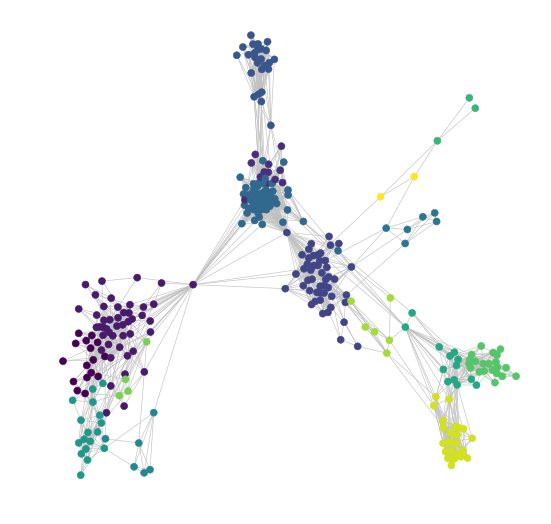

In [20]:
G = nx.from_numpy_matrix(adj_matrix)
G_dend = community.generate_dendrogram(G)
parts = community.partition_at_level(G_dend,0)
comm_id = [parts.get(node) for node in G.nodes()]
pos = nx.spring_layout(G, iterations=150)
fig = plt.figure(figsize=(9, 9))
nx.draw_networkx(G, pos = pos, node_color = comm_id,
                 node_size = 50, with_labels = False,
                 width=0.6, edge_color ='silver')
plt.axis("off")
plt.show()

In [21]:
def make_hist(df_info, df_comm, comm_id, friends_list):
    #Make new columns
    df_info['comm_id'] = None
    df_info.set_index('users_id', inplace=True)
    df_info['comm_id'].loc[friends_list] = comm_id
    df_info.reset_index(inplace=True)
    
    columns = ['city_id', 'occupt_id', 'school_id', 'sex_id', 'univer_id']
    f, ax = plt.subplots(len(columns), 1, figsize=(15, 4*len(columns)))
        
    for i, col in enumerate(columns):    
        ax[i].set_title(col)
        data = []
        labels = []
        for comm in df_info['comm_id'].dropna().unique():
            data.append(df_info[df_info['comm_id'] == comm][col].dropna())
            labels.append(str(comm+1) + 'st community')
        
        ax[i].hist(data, bins=20, alpha=0.8, label=labels)
        ax[i].legend()
    
    plt.show()

In [22]:
def make_bar(df_info, df_comm, comm_id, friends_list):
    
    columns = ['city_name', 'occupt_name', 'school_name', 'sex_id', 'univer_name']
    f, ax = plt.subplots(len(columns), 1, figsize=(15, 10*len(columns)))
    f.subplots_adjust(hspace=1)
    
    for i, col in enumerate(columns):    
        ax[i].set_title(col)
        
        ind = df_info[col].dropna().value_counts().index
        count = df_info[col].dropna().value_counts().as_matrix()
        ind = ind[count >= 2]
        count = count[count >= 2]
        
        width = 0.35
        size = len(ind)
        
        ax[i].bar(np.arange(size), count, width, alpha=0.8)
        ax[i].set_xticks(np.arange(size))
        
        if col == 'sex_id':
            sex_dict= {1: 'man', 2: 'women', 3: 'unknown'}
            ind = list(map(lambda x: sex_dict[x], ind))
        ax[i].set_xticklabels(ind, rotation = 90)
plt.show()

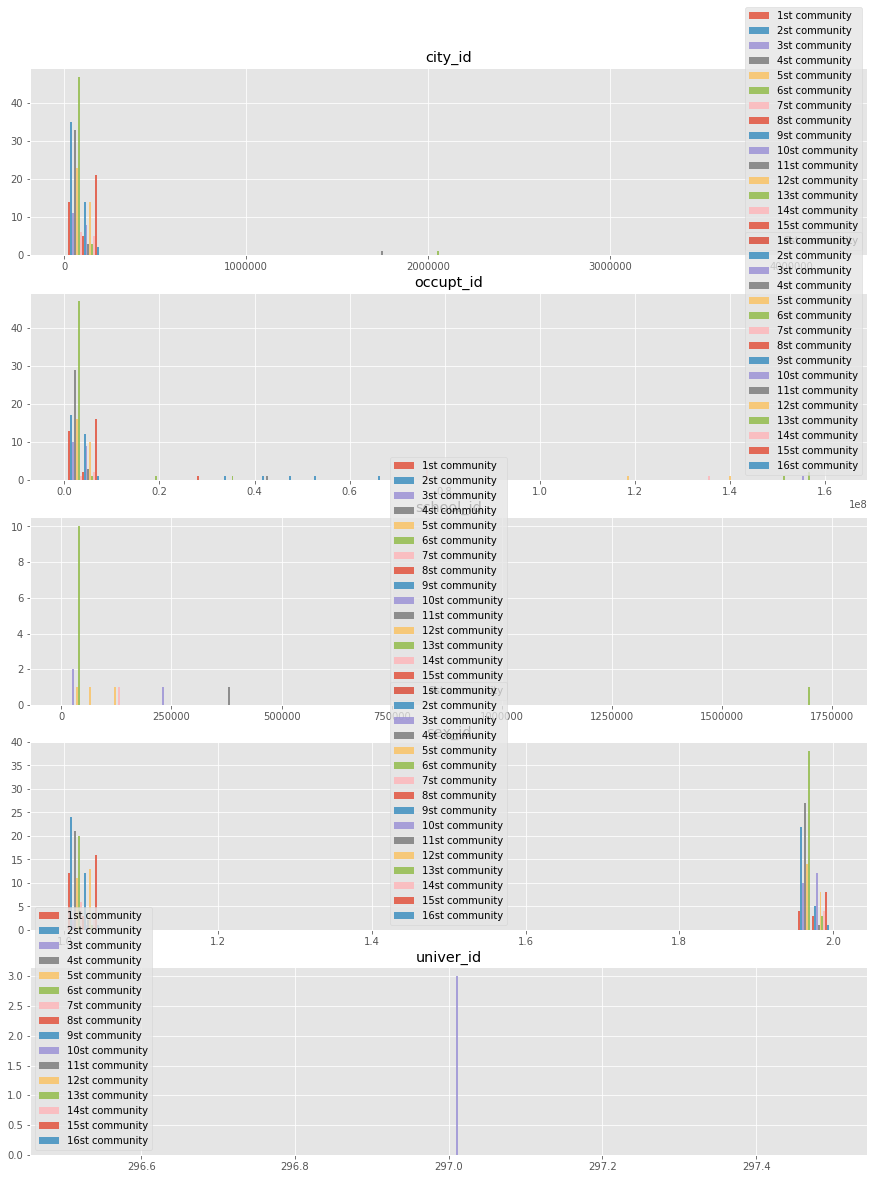

In [23]:
make_hist(df_info, df_comm, comm_id, friends_list)

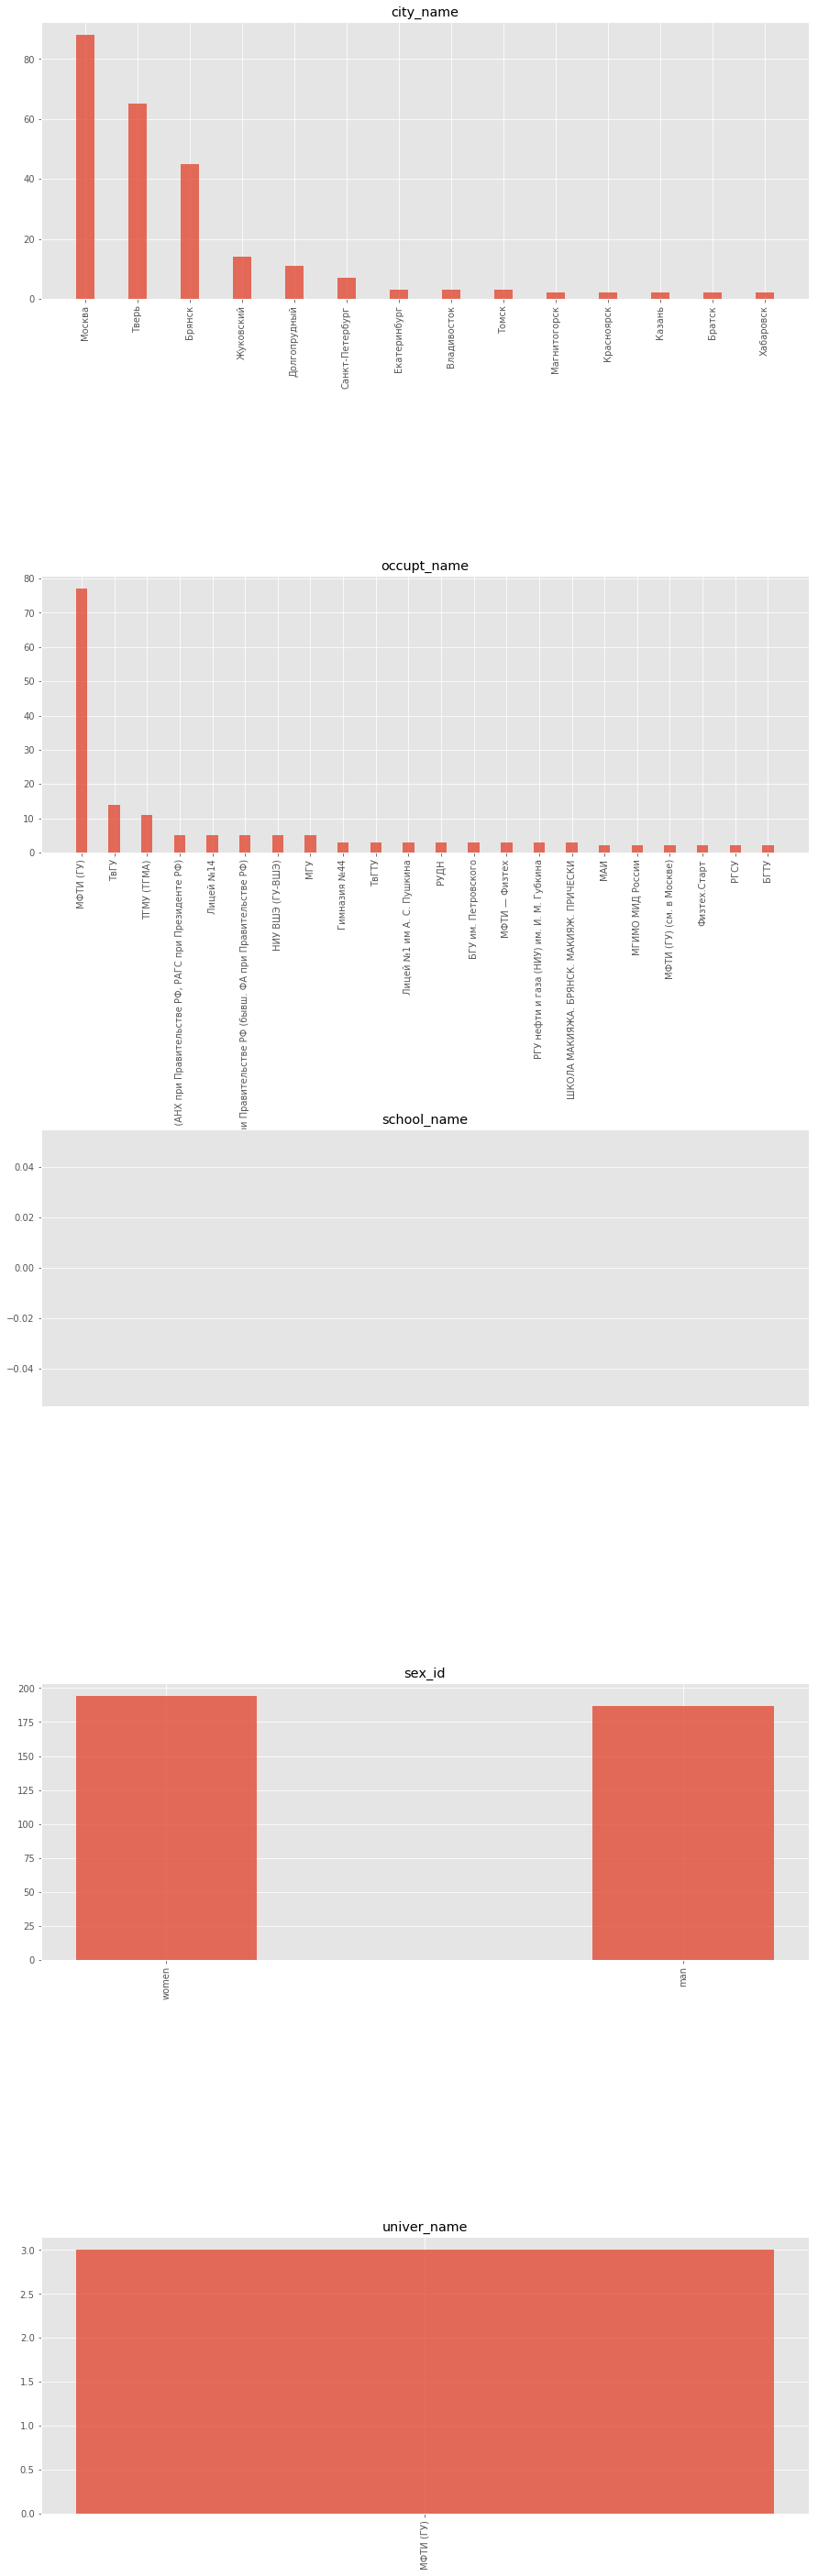

In [24]:
make_bar(df_info, df_comm, comm_id, friends_list)

In [25]:
def look_people():
    print('You have {} community'.format(df_info['comm_id'].dropna().unique().max() + 1))
    print('Enter a number of community')
    comm = input()
    try:
        comm = int(comm)
        if comm in df_info['comm_id'].dropna().unique():
            print('Look at people in this community')
            com_users_id = df_info[df_info['comm_id'] == comm]['users_id'].as_matrix()
            #df = df_comm.loc[com_users_id][com_users_id]
            #adj = df.as_matrix()
            #ind = adj.sum(axis=1).argsort()[-5:][::-1]
            #ind = df.reset_index()['users_id'][ind].as_matrix()
            df_info.set_index('users_id', inplace=True)
            for i in com_users_id:
                print('\t{} {}'.format(df_info.loc[i]['first_name'], df_info.loc[i]['last_name']))
            df_info.reset_index('users_id', inplace=True)
        else:
            print('Sorry, you have not commuity with this number')
    except:
        print('Sorry, enter a number')
    

In [26]:
look_people()

You have 16 community
Enter a number of community
0
Look at people in this community
	Alexander Tessler
	Виолетта Алексеева
	Никита Мышев
	Александра Павлова
	Вика Пальчикова
	Екатерина Орешкина
	Анастасия Шалыгина
	Владька Байдаков
	Дарья Орешкина
	Валерия Боганич
	Арина Лебезова
	Елена Радионова
	Катерина Калинина
	Саша Коршунова
	Николай Перов
	Анита Пальчикова


In [27]:
look_people()

You have 16 community
Enter a number of community
1
Look at people in this community
	Татьяна Васильева
	Светлана Малярова
	Александр Травкин
	Таня Афанасьева
	Владимир Клюшников
	Анаид Чивчян
	Полина Меженская
	Степан Григорьев
	Александр Коляда
	Мария Соколова
	Даниил Солод
	Мария Гущина
	Роман Ёлкин
	Владимир Прокофьев
	Георгий Попов
	Даша Павлова
	Дима Шухов
	Мария Баглай
	Данила Кочнев
	Алиса Маковская
	Артём Колотильщиков
	Анна Петрова
	Полина Алексеева
	Артем Савенков
	Эвелина Клюшина
	Карен Атаян
	Карина Агаханова
	Арьян Красавин
	Анна Савельева
	Егор Марченко
	Мария Бойцова
	Иван Трубин
	Ирина Рябова
	Максим Титов
	Павел Антипов
	Ефим Житомирский
	Николай Филиппов
	Павел Сибилев
	Linda Shaipova
	Даша Кудряшова
	Эмиль Житомирский
	Анна Иванова
	Николай Филиппов
	Данила Данилыч
	Мария Стихарева
	Екатерина Галушка


In [28]:
look_people()

You have 16 community
Enter a number of community
2
Look at people in this community
	Яков Львович
	Евгений Пелевин
	Darya Moroz
	Микаил Бандалиев
	Тимур Ваганов
	Данил Шамсимухаметов
	Владислав Пикиневич
	Кирилл Чумачков
	Виктория Головнева
	Николай Магера
	Никита Мокров
	Стас Округ


In [29]:
look_people()

You have 16 community
Enter a number of community
3
Look at people in this community
	Оксана Солукова
	Ирина Шегедина
	Софья Копачёва
	Антон Невструев
	Никита Маруев
	Сергей Расновский
	Денис Вашето
	Альбина Худулова
	Дарья Пашкова
	Виталий Солеварченко
	Иван Скориков
	Денис Редин
	Диана Лосева
	Анна Шпилько
	Илья Вернер
	Катерина Донешко
	Юрий Кондратенко
	Иван Иванов
	Юля Башкатова
	Мария Ускова
	Руслан Николаенко
	Юля Полякова
	Серёжа Зайцев
	Владимир Бездудный
	Женя Азаров
	Екатерина Леонтьева
	Александр Декун
	Аня Репалова
	Мурад Мамедов
	Настасья Назарова
	Денис Полищук
	Влад Слизкий
	Valeria Romanova
	Daniil Zhilinsky
	Егор Кельмяшкин
	Иван Иванов
	Daniil Fradkin
	Diana Bukvich
	Настя Караулова
	Edgar Oganisyan
	Elizaveta Yasinskaya
	Мария Овсеенко
	Егор Редин
	Данил Архипов
	Катя Шишонкова
	Даниил Иванов
	Георгий Громов
	Ольга Логвинова


In [30]:
look_people()

You have 16 community
Enter a number of community
4
Look at people in this community
	Александр Ненашев
	Антон Васильков
	Леонид Лысков
	Егор Чёткин
	Владислав Рыхлов
	Дмитрий Шептунов
	Полина Колыхалова
	Алексей Гальтяев
	Даниил Монахов
	Вика Клементьева
	Дмитрий Ивашинин
	Катерина Никулина
	Дмитрий Аверьянов
	Александра Прохорова
	Александр Скорб
	Айрат Валиев
	Валерия Федина
	Тамара Каплун
	Искандар Мустафин
	Рина Новикова
	Павел Троян
	Наталья Лунёва
	Рената Блажко
	Мария Минаева
	Мария Фофанова


In [31]:
look_people()

You have 16 community
Enter a number of community
5
Look at people in this community
	Мария Филиппова
	Люба Ермолаева
	Антонина Колчина
	Александр Кузнецов
	Сергей Лугинин
	Роман Шарапов
	Никита Воробьев
	Данила Хайдуков
	Рома Маслов
	Даниил Крейндлин
	Марина Дмитриева
	Алексей Кузнецов
	Андрей Андрияйнен
	Анна Костырева
	Мария Морозова
	Дарина Волконская
	Максим Черкасов
	Егор Бова
	Артём Владимиров
	Иван Толстов
	Алёна Алфёрова
	Иван Бондарев
	Алина Шипицына
	Юлия Ярабаева
	Алексей Подкидышев
	Рустем Юнусов
	Георгий Зеленфройнд
	Евгений Евтушенко
	Анастасия Тесленко
	Леонид Берлин
	Максим Макаров
	Анастасия Шеренешева
	Карл Зубров
	Екатерина Тримбач
	Мария Калужская
	Мария Качуровская
	Кирилл Гусев
	Никита Торопцев
	Николай Шумков
	Сергей Ефимов
	Никита Дубовик
	Глеб Овсянников
	Ярослав Унтилов
	Аяжан Рамазанова
	Фёдор Кондрашов
	Константин Мордвинцев
	Дарья Котова
	Денис Стукалов
	Владик Негависпыч
	Вадим Карцев
	Дмитрий Петров
	Александр Филиппов
	Намина Мальмакова
	Alikazhy Kobdik

In [32]:
look_people()

You have 16 community
Enter a number of community
6
Look at people in this community
	Елена Новикова
	Влада Сафронова
	Оксана Цуканова
	Дарья Евелевич-Новикова
	Светлана Фроленкова
	Елена Новикова


In [33]:
look_people()

You have 16 community
Enter a number of community
7
Look at people in this community
	Маша Меньшакова
	Саша Кубрак
	Саша Меньшаков
	Катя Меньшакова
	Satine Alikhanyan
	Юрий Поляков


In [34]:
look_people()

You have 16 community
Enter a number of community
8
Look at people in this community
	Александр Кутузов
	Никита Березкин
	Инна Купоросова
	Валерия Черезова
	Марина Балакирева
	Полина Соколова
	Денис Токин
	Дарья Ваганова
	Глеб Паршин
	Анастасия Земскова
	Екатерина Серова
	Дарина Афанасьева
	Евгений Решетнюк
	Екатерина Ильина
	Арина Логина
	Софья Куркова
	Anna Wi


In [35]:
look_people()

You have 16 community
Enter a number of community
9
Look at people in this community
	Игорь Горбоносов
	Иван Дубровин
	Илья Алябьев
	Иван Скворцов
	Кирилл Саушкин
	Александр Кондаков
	Дмитрий Митин
	Анастасия Щедрякова
	Андрей Драшеевич
	Иван Ипатов
	Слава Бирюков
	Давид Родин
	Игорь Котуа


In [36]:
look_people()

You have 16 community
Enter a number of community
10
Look at people in this community
	Алина Бубненко
	Даниил Лесков
	Angelinka Leskova


In [37]:
look_people()

You have 16 community
Enter a number of community
11
Look at people in this community
	Еленка Силенок
	Наташа Калашникова
	Настя Ноготкова
	Дима Зинченко
	Илья Полудкин
	Аня Кирюшина
	Аня Седова
	Полина Губская
	Лера Шаталова
	Виктория Зуйкова
	Александра Крылова
	Алиса Емельянова
	Дима Романенков
	Михаил Кузякин
	Женечка Емельянова
	Слава Евстифеев
	Евдокия Гороход
	Serafim Knyazev
	Антон Рябоконь
	Хлеб Черный
	Ксюша Кирюшина


In [38]:
look_people()

You have 16 community
Enter a number of community
12
Look at people in this community
	Татьяна Русина
	Миша Плеханов
	Марк Бурдуковский
	Никита Кастрюков


In [39]:
look_people()

You have 16 community
Enter a number of community
13
Look at people in this community
	Ольга Москаленко
	Виктор Седнев
	Кирилл Жданов
	Елизавета Фурсова
	Frozen Bryant
	Александр Фомин


In [40]:
look_people()

You have 16 community
Enter a number of community
14
Look at people in this community
	Алёна Савкина
	Мэрик Цынгуев
	Николай Савина
	Полина Петрова
	Irina Ekimenko
	Ольга Римша
	Наташа Максимова
	Влада Никифорова
	Дима Миклашевич
	Карина Мильская
	Рита Буторина
	Настя Строкова
	Александра Иваненко
	Миша Захарушкин
	Диана Владимирова
	Алина Хованец
	Анна Пластова
	Дашенька Ланько
	Yan Bormosov
	Лилия Шокарева
	Алексей Шараев
	Кирилл Лещишин
	Анастасия Крюкова
	Илья Перевозников


In [41]:
look_people()

You have 16 community
Enter a number of community
15
Look at people in this community
	Алина Козменко
	Дима Савин


## Make map of your frends

In [42]:
def make_cord_city(df):

    df.set_index('city_name', inplace=True)
    df['lat'] = np.nan
    df['lon'] = np.nan
    for city in tqdm(df.index):
        ADD_CORD = False
        #Check Russian wikipedia
        if ADD_CORD == False:
            WIKI_URL = 'https://ru.wikipedia.org/wiki/' + str(city)
            req = requests.get(WIKI_URL)
            soup = bs(req.content, 'lxml')
            w = soup.find_all("script")[1]
            for split_text in re.split(r'[{}]', w.text):
                if 'lat' in split_text and 'lon' in split_text:
                    cord = re.split(r'[,:]', split_text)

                    try:
                        df['lat'][city] = float(cord[1])
                        df['lon'][city] = float(cord[3])
                        ADD_CORD = True
                    except:
                        None

                    
        if ADD_CORD == False:
            WIKI_URL = 'https://en.wikipedia.org/wiki/' + str(city)
            req = requests.get(WIKI_URL)
            soup = bs(req.content, 'lxml')
            w = soup.find_all("script")[1]
            for split_text in re.split(r'[{}]', w.text):
                if 'lat' in split_text and 'lon' in split_text:
                    cord = re.split(r'[,:]', split_text)
    
                    try:
                        df['lat'][city] = float(cord[1])
                        df['lon'][city] = float(cord[3])
                        ADD_CORD = True
                    except:
                        None
    
    df.reset_index(inplace=True)
    return df

In [43]:
df_city = make_cord_city(df_city)

HBox(children=(IntProgress(value=0, max=800), HTML(value='')))

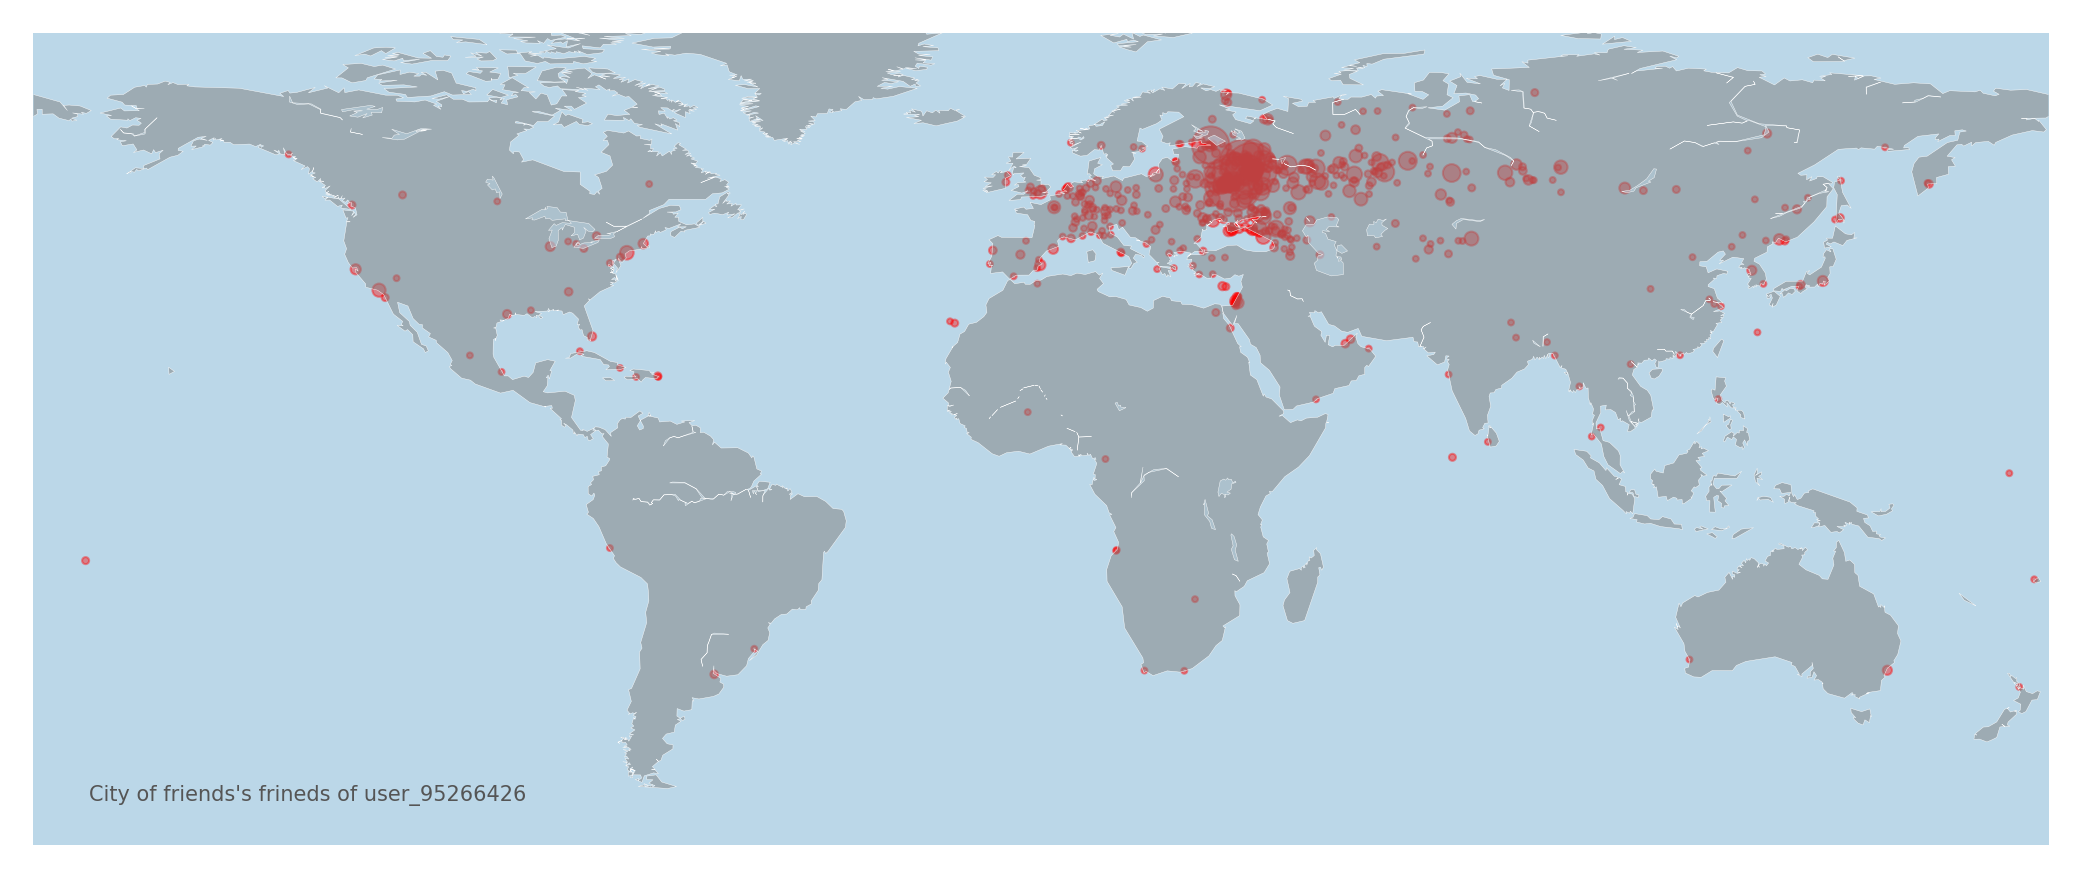

In [44]:
### FROM:https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
 
my_dpi=300
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#BBD7E8', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
 
# Add a point per position
m.scatter(df_city['lon'], df_city['lat'],
          s= 2*np.sqrt(df_city['count']),
          c='r', alpha=0.4, cmap="Set1")
 
plt.text( -170, -58, 'City of friends\'s frineds of user_{}'.format(user_id),
         ha='left', va='bottom', size=5, color='#555555' )
 
# Save as png
plt.savefig('info_user_id/map_{}.png'.format(user_id), dpi = my_dpi, bbox_inches='tight')
plt.show()

### END FROM

In [45]:
try:
    ### FROM: https://python-graph-gallery.com/313-bubble-map-with-folium/
    m = folium.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2)

    data = df_city.dropna()
    # I can add marker one by one on the map
    for i in range(0,len(data)):
        folium.Circle(
            location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
            popup=data.iloc[i]['city_name'],
            radius=np.sqrt(data.iloc[i]['count'])*1000.0,
            color='crimson',
            fill=True,
            fill_color='crimson').add_to(m)

    # Save it as html
    m.save('info_user_id/map_{}.html'.format(user_id))
    print('Open the file')
    ### END FROM
except:
    None

Open the file
